In [1]:
import findspark

findspark.init()

from pyspark import SparkContext
sc=SparkContext("local","quiz")

21/11/03 05:26:18 WARN Utils: Your hostname, jeongsobin-ui-MacBookPro.local resolves to a loopback address: 127.0.0.1; using 172.30.1.53 instead (on interface en0)
21/11/03 05:26:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/03 05:26:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
data=sc.textFile("pagerank_data.txt")

In [3]:
pro_data=data.map(lambda x:[int(j) for j in x.split(" ")]).map(lambda x:(x[0],set(x[1:])))

# Algorithm소개

1단계. Map 함수의 입력데이터

-pageId,{set of outgoing links}

2단계. Reduce함수의 키값

-PageID (pageid를 키값으로 reducebykey를 이용해 랭크값 더할예정)

3단계.맵 함수에서 출력할 키-값 쌍 정의

-(linked PageID,PageRank credit to distribute)

4단계.리듀스 함수를 정의

-(PageID,PageRank of the current iteration)


Flow->

입력데이터는 페이지아이디와 페이지아이디가 향하는 다른 페이지아이디들인 target으로 구성 (key,target sets)

flatMap으로 키값마다 (target,target노드가 가지는 가중치)페어로 바꾼후 reducebykey이용해 모든 rank값을 더함

dead-end와 spider trap의 문제를 해결하기 위해 teleport기능이 필요함.

teleport를 하기 위해 mapvalues이용해 키별로 페이지 랭크값에 d*v+1/N*(1-d) 적용시킴

수렴값은 현재 페이지랭크값의 평균에서 이전 페이지 랭크값의 평균을 빼고

maxIter를 20으로 두고 지정한 수렴값보다 적으면 반복문을 종료하고 아니면 계속 실행

In [4]:
N=30000
d=0.85
convergenceTol=1e-12
compare_convergence=[]
maxIter=20
pr=sc.broadcast([1./float(N) for _ in range(N)])

for i in range(maxIter):
    data_result=pro_data.flatMap(lambda x:[(target,pr.value[x[0]]/len(x[1])) for target in x[1]])\
    .reduceByKey(lambda x,y:x+y).sortBy(lambda x: x[0]).mapValues(lambda v:d*v+1/N*(1-d))
    
    pr_new=data_result.map(lambda t:t[1]).collect()
    
    pr_new.insert(0,0)
    
    err=sum(pr.value)/N-sum(pr_new)/N
    
    if err<convergenceTol:
        
        break
    
    pr=sc.broadcast(pr_new)
    
    compare_convergence.append(err)
 

/opt/homebrew/Cellar/apache-spark/3.1.2/libexec/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


In [5]:
compare_convergence

[1.6666666364481856e-10,
 1.4166666648232412e-10,
 1.2041666687894305e-10,
 1.0235416647677879e-10,
 8.700104125894479e-11,
 7.395088565760512e-11,
 6.285825261313034e-11,
 5.3429514603592614e-11,
 4.5415087387642734e-11,
 3.8602824360472673e-11,
 3.2812400711822783e-11,
 2.7890541188146847e-11,
 2.370695933534778e-11,
 2.0150915732862398e-11,
 1.7128278186246976e-11,
 1.4559036525733753e-11,
 1.2375181276589025e-11,
 1.0518903138117836e-11,
 8.941068907117582e-12,
 7.599907905959675e-12]

## iteration이 진행됨에 따라 수렴값이 어느정도 줄어드는지 확인하기 위한 그래프

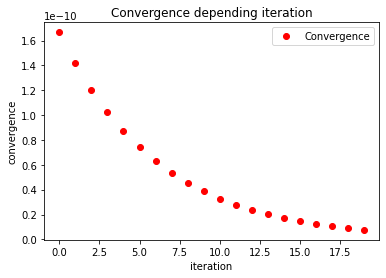

In [6]:
import matplotlib.pyplot as plt
plt.plot(list(range(maxIter)),compare_convergence,'ro')

plt.xlabel('iteration')
plt.ylabel('convergence')
plt.title('Convergence depending iteration')

plt.legend(['Convergence'])

plt.show()

## pagerank 결과값

In [7]:
data_result.sortBy(lambda x:x[1],False).collect()

[(1, 0.0008539419616040584),
 (2, 0.0008539419616040584),
 (3, 0.0008539419616040584),
 (4, 0.0008539419616040584),
 (5, 0.0008539419616040584),
 (6, 0.0008539419616040584),
 (7, 0.0008539419616040584),
 (8, 0.0008539419616040584),
 (9, 0.0008539419616040584),
 (10, 0.0008539419616040584),
 (11, 0.0008539419616040584),
 (12, 0.0008539419616040584),
 (13, 0.0008539419616040584),
 (14, 0.0008539419616040584),
 (15, 0.0008539419616040584),
 (16, 0.0008539419616040584),
 (17, 0.0008539419616040584),
 (18, 0.0008539419616040584),
 (19, 0.0008539419616040584),
 (20, 0.0008539419616040584),
 (21, 0.0008539419616040584),
 (22, 0.0008539419616040584),
 (23, 0.0008539419616040584),
 (24, 0.0008539419616040584),
 (25, 0.0008539419616040584),
 (26, 0.0008539419616040584),
 (27, 0.0008539419616040584),
 (28, 0.0008539419616040584),
 (29, 0.0008539419616040584),
 (30, 0.0008539419616040584),
 (31, 0.0008539419616040584),
 (32, 0.0008539419616040584),
 (33, 0.0008539419616040584),
 (34, 0.00085394196